# Goal
The purpose of this notebook is to forecast asthma & COPD hospitalizations as well as their general mortality rates and rates of occurence from the smoke estimate.

The health indicators were cleaned in the [`Extension-Data_Exploration.ipynb`](Extension-Data_Exploration.ipynb) notebook.

## License

Note that the code lies under the standard [MIT licence](./LICENSE).

# 0. Set-up
This notebooks assumes that the user has a working Jupyter Notebook Python 3 set-up. Instructions on installing them can be found [here](https://docs.jupyter.org/en/latest/install/notebook-classic.html).

Specifically, here are the following Python modules that we need for this work. Some are standard modules that come installed with Python and others should come installed as part of the [Anaconda](https://docs.jupyter.org/en/latest/install/notebook-classic.html) distribution. 

If modules are not found, they can be readily installed with the following terminal commands:

```bash
    pip install <module name>
```
or 
```bash
   conda install <module name>
```

In [41]:
# a highly recommended progress bar for loops.
from tqdm.auto import tqdm, trange
# a recommended module to read and wrangle data
import pandas as pd
# recommended modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Best for array manipulation
import numpy as np

In [42]:
# Let's read in the health data.
health_data = pd.read_csv("./intermediate/combined_health_data.csv")
# peak at the data
health_data.head()

,Year,Deaths: Asthma (OR),Deaths: Chronic obstructive pulmonary disease (OR),Deaths: Chronic respiratory diseases (OR),Incidence: Asthma (OR),Incidence: Chronic obstructive pulmonary disease (OR),Incidence: Chronic respiratory diseases (OR),Prevalence: Asthma (OR),Prevalence: Chronic obstructive pulmonary disease (OR),Prevalence: Chronic respiratory diseases (OR),...,Asthma: Crude HR Ages 15-34 (DC),Asthma: Crude HR Ages 35-64 (DC),Asthma: Crude HR Ages 65+ (DC),Asthma: Total Hospitalizations (DC),COPD: Age-Adjusted HR (DC),COPD: Crude HR (DC),COPD: Crude HR Ages 25-44 (DC),COPD: Crude HR Ages 45-64 (DC),COPD: Crude HR Ages 65-84 (DC),PDR Age-Adjusted (DC)
0,1990,0.260799,4.352008,5.066918,127.119372,29.431595,222.738686,982.016766,475.081323,1329.252444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991,0.258153,4.406063,5.126562,117.750089,29.793294,208.502360,899.341041,481.446187,1264.845025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992,0.261474,4.547597,5.286948,109.420378,30.183304,195.875842,825.951328,487.333620,1207.356910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993,0.268718,4.840284,5.610785,102.433649,30.550106,185.435955,765.234478,492.150495,1160.079064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994,0.270207,4.907768,5.690183,97.124498,30.839320,177.791042,720.584432,495.242339,1125.107384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# let's look at the columns of the data
health_data.columns

Index(['Year', 'Deaths: Asthma (OR)',
       'Deaths: Chronic obstructive pulmonary disease (OR)',
       'Deaths: Chronic respiratory diseases (OR)', 'Incidence: Asthma (OR)',
       'Incidence: Chronic obstructive pulmonary disease (OR)',
       'Incidence: Chronic respiratory diseases (OR)',
       'Prevalence: Asthma (OR)',
       'Prevalence: Chronic obstructive pulmonary disease (OR)',
       'Prevalence: Chronic respiratory diseases (OR)',
       'Asthma: Age-Adjusted HR (DC)', 'Asthma: Crude HR (DC)',
       'Asthma: Crude HR Ages 0-4 (DC)', 'Asthma: Crude HR Ages 5-14 (DC)',
       'Asthma: Crude HR Ages 15-34 (DC)', 'Asthma: Crude HR Ages 35-64 (DC)',
       'Asthma: Crude HR Ages 65+ (DC)', 'Asthma: Total Hospitalizations (DC)',
       'COPD: Age-Adjusted HR (DC)', 'COPD: Crude HR (DC)',
       'COPD: Crude HR Ages 25-44 (DC)', 'COPD: Crude HR Ages 45-64 (DC)',
       'COPD: Crude HR Ages 65-84 (DC)', 'PDR Age-Adjusted (DC)'],
      dtype='object')

In [46]:
# Let's read in the smoke estimates.
smoke_estimates = pd.read_csv('./output/redmond_smoke_estimates.csv', index_col=0)
# peak at the data
smoke_estimates.head()

,Fire_Year,annual_smoke_intake,daily_avg_fire_szn
0,1963,1602.822794,8.710993
1,1964,1557.303033,8.463603
2,1965,1373.855852,7.466608
3,1966,1906.362476,10.360666
4,1967,1995.901905,10.847293


In [47]:
# let's rename the table
smoke_estimates = smoke_estimates.rename(columns= {"daily_avg_fire_szn": "Annual Smoke Index"}).drop(columns = 'annual_smoke_intake')

## Check Correlation

Based on the health data and the smoke estimates, let's see the pairwise Pearson correlation plots.

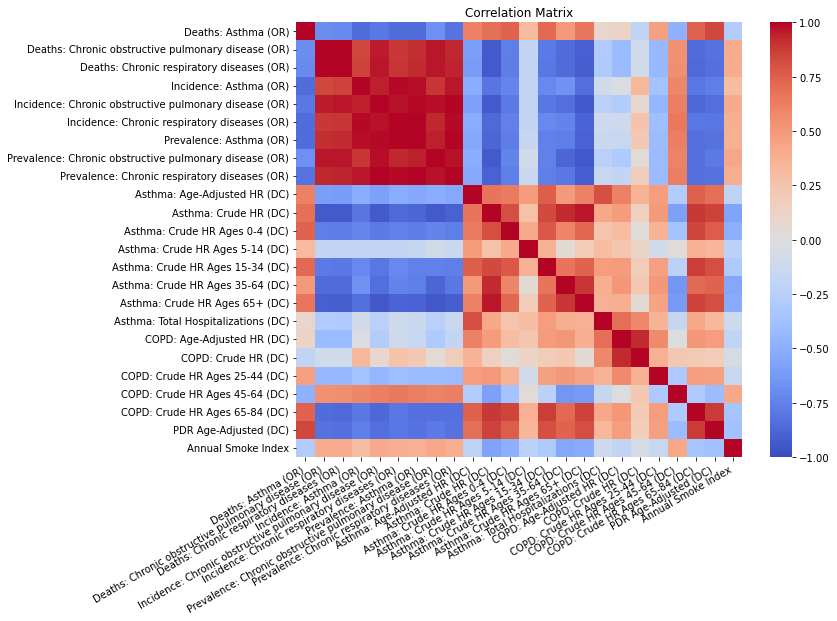

In [17]:
# Merge dataframes on the common column 'Year'
merged_df = pd.merge(health_data, smoke_estimates, left_on='Year', right_on='Fire_Year', how='inner').drop(columns=['Fire_Year'])

# Analyze correlation between smoke intake and hospitalization rates/incidence
correlation_matrix = merged_df.drop(columns=['Year']).dropna().corr()
#[['annual_smoke_intake', 'Asthma: HR Age-Adjusted (DC)', 'COPD: HR Age-Adjusted (DC)', 'Incidence: Asthma (OR)', 'Incidence: Chronic obstructive pulmonary disease (OR)']].corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
h = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# Tilt x-axis labels
_ = h.set_xticklabels(h.get_xticklabels(), rotation=30, ha='right')
plt.title('Correlation Matrix')
plt.show()

We see a large cluster showing that the state level data are highly correlated. Let's print out the values for just the indicator and the Annual Smoke Index.

In [18]:
correlation_matrix[['Annual Smoke Index']]

,Annual Smoke Index
Deaths: Asthma (OR),-0.289382
Deaths: Chronic obstructive pulmonary disease (OR),0.399980
Deaths: Chronic respiratory diseases (OR),0.404039
Incidence: Asthma (OR),0.297920
Incidence: Chronic obstructive pulmonary disease (OR),0.412809
Incidence: Chronic respiratory diseases (OR),0.385212
Prevalence: Asthma (OR),0.380116
Prevalence: Chronic obstructive pulmonary disease (OR),0.429900
Prevalence: Chronic respiratory diseases (OR),0.396225
Asthma: Age-Adjusted HR (DC),-0.216713


Let's plot this as a heatmap.

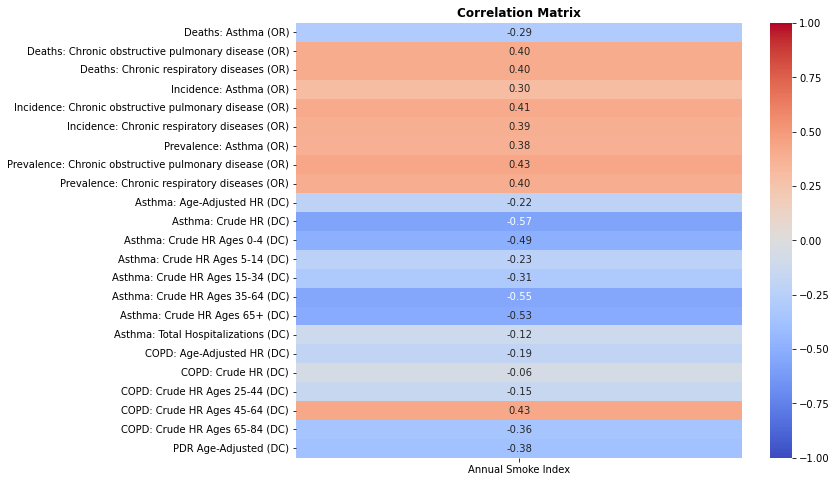

In [48]:
# Plot a heatmap
plt.figure(figsize=(10, 8))
h = sns.heatmap(correlation_matrix[['Annual Smoke Index']].iloc[:-1,:], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# Tilt x-axis labels
_ = h.set_xticklabels(h.get_xticklabels(), rotation=0, ha='center')
plt.title('Correlation Matrix', weight= 'bold')
plt.show()

## 1. Univariate ARIMA Forecast of Smoke
---

In [59]:
# read all smoke data
all_smoke = pd.read_csv("./output/wildfire_smoke_forecast_1963-2050.csv", index_col=0)
# peek at data
all_smoke.head()

,Fire_Year,Annual Smoke Index
0,1963,8.710993
1,1964,8.463603
2,1965,7.466608
3,1966,10.360666
4,1967,10.847293


In [27]:
# Gather forecast into the existing set of full health data
merged_df = all_smoke.merge(health_data, left_on='Fire_Year', right_on='Year', how='left').drop(columns=['Year']).rename(columns = {'Fire_Year': "Year"})
# Set index to be August 1 of each year
merged_df.index = pd.to_datetime(merged_df['Year'], format = "%Y") + pd.DateOffset(months=7)

### Load VARMAX Model
---
We use the Statsmodels's [VARMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html) model to predict multiple, linked variables at once.

To forecast the respiratory health indicators, I use a Vector Autoregressive Moving Average with eXogenous regressors model (VARMAX) to model multivariate time series using my smoke forecast and time as the exogenous variables. I use a multivariate approach as many of the health indicators are understandably strongly linked. Unlike ARIMA, VARMAX allows us to model the effects of one of these indicators on other variables. Specifically, I forecast the future for sets of variables at a time as the model cannot handle more than five endogenous variables at a time due to the small number of data points. To forecast asthma rates, I consider the number of deaths, incidence, and prevalence at the state level and the overall age-adjusted hospitalization rate & crude hospitalization rates for those above 65 at the county level at once. I use the same corresponding variables to forecast COPD. Additionally, I also forecast the overall mortality, incidence, and prevalence rates for all chronic respiratory illnesses at the state level.

When building the model, I split the data into 80% train and 20% test and conducted a grid search for the best hyperparameter values of p & q using the Euclidean norm of the Root Mean Squared Error to track model fit. I don’t use BIC as it is only valid when n is greater than the number of parameters in the model; in this case, the model has many parameters and very few data points. I take the Euclidean norm to ensure that the model predictions are valid for all endogenous variables and not just one at the expense of another.

In [28]:
# load necessary libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse
import itertools
import warnings

Because the dataset is small, VARMAX can't exceed modeling 5 predictors at once. So, we'll model all Asthma first, all COPD, then all Chronic RIs.

In [ ]:
# gather relevant endogenous variables for each set: Asthma, COPD, and Chronic RIs.
endog_col_dict= {
    "Asthma": [
        'Deaths: Asthma (OR)',
        'Incidence: Asthma (OR)',
        'Prevalence: Asthma (OR)',
        'Asthma: Age-Adjusted HR (DC)',
        'Asthma: Crude HR Ages 65+ (DC)', 
    ],
    "COPD": [
        'Deaths: Chronic obstructive pulmonary disease (OR)',
        'Incidence: Chronic obstructive pulmonary disease (OR)',    
        'Prevalence: Chronic obstructive pulmonary disease (OR)',
        'COPD: Age-Adjusted HR (DC)',
        'COPD: Crude HR Ages 65-84 (DC)',
    ],
    "Chronic RIs": [
        'Deaths: Chronic respiratory diseases (OR)', 
        'Incidence: Chronic respiratory diseases (OR)',
        'Prevalence: Chronic respiratory diseases (OR)',
    ]
}

# we have our set of exogenous variables: Time & Forecasted Smoke Estimates.
exog_cols = [
    'Year', 
    'Annual Smoke Index',
]

### Now, we're going to find the best p, q values using RMSE and preset grid search of 1-5 for each value.

In [36]:
def get_best_VARMAX(endog_cols, exog_cols=exog_cols):
    """
    Get the best P,Q Values using the lowest RMSE errors of the validation set.
    Note, this function assumes all the data is stored together as one data frame.
    
    Parameters:
        endog_cols: list of column names representing the endogenous variables.
        exog_cols: list of column names representing the exogenous variables.
    Return: 
        None
    """
    # Get just data for which all columns exist.
    df_selected = merged_df[endog_cols + exog_cols].dropna()
    # Split the data into training and testing sets
    train_size = int(len(df_selected) * 0.8)
    train, test = df_selected.iloc[:train_size], df_selected.iloc[train_size:]

    # Define the range of p and q values for the grid search
    p_values = range(1, 5)  # Adjust the range based on your data
    q_values = range(1, 5)  # Adjust the range based on your data

    # Initialize variables to store optimal values
    best_p, best_q = 0, 0
    best_rmse = float('inf')

    # Perform grid search
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for p, q in itertools.product(p_values, q_values):
            try:
                # Fit VARMAX model
                model = VARMAX(train[endog_cols], exog=train[exog_cols], order=(p, q))
                results = model.fit(disp=False, freq='A')

                # Forecast future values
                forecast_steps = len(test)
                forecast = results.get_forecast(steps=forecast_steps, exog=test[exog_cols])

                # Evaluate the model
                rmse_values = rmse(test[endog_cols], forecast.predicted_mean[endog_cols])
                rmse_value = np.linalg.norm(rmse_values)

                # Update optimal values if current RMSE is better
                if rmse_value < best_rmse:
                    best_p, best_q = p, q
                    best_rmse = rmse_value

            except Exception as e:
                print(f"Error for p={p}, q={q}: {e}")

    print(f"Optimal p: {best_p}, Optimal q: {best_q}, Minimum RMSE: {best_rmse}")

In [111]:
%%time
# Get Best Parameters for Asthma
get_best_VARMAX(endog_col_dict['Asthma'])

Error for p=2, q=1: Schur decomposition solver error.
Error for p=2, q=2: Schur decomposition solver error.
Error for p=2, q=3: Schur decomposition solver error.
Error for p=2, q=4: Schur decomposition solver error.
Error for p=3, q=1: Matrix is not positive definite
Error for p=3, q=2: Matrix is not positive definite
Error for p=3, q=3: Matrix is not positive definite
Error for p=3, q=4: Matrix is not positive definite
Error for p=4, q=1: Matrix is not positive definite
Error for p=4, q=2: Matrix is not positive definite
Error for p=4, q=3: Matrix is not positive definite
Error for p=4, q=4: Matrix is not positive definite
Optimal p: 1, Optimal q: 1, Minimum RMSE: 8.083113936979128
Wall time: 21.5 s


In [180]:
%%time
# Get Best Parameters for COPD
get_best_VARMAX(endog_col_dict['COPD'])

Error for p=2, q=1: Schur decomposition solver error.
Error for p=2, q=2: Schur decomposition solver error.
Error for p=2, q=3: Schur decomposition solver error.
Error for p=2, q=4: Schur decomposition solver error.
Error for p=3, q=1: Matrix is not positive definite
Error for p=3, q=2: Matrix is not positive definite
Error for p=3, q=3: Matrix is not positive definite
Error for p=3, q=4: Matrix is not positive definite
Error for p=4, q=1: Matrix is not positive definite
Error for p=4, q=2: Matrix is not positive definite
Error for p=4, q=3: Matrix is not positive definite
Error for p=4, q=4: Matrix is not positive definite
Optimal p: 1, Optimal q: 4, Minimum RMSE: 21.433162432342556
Wall time: 19.6 s


In [113]:
%%time
# Get Best Parameters for Chronic RIs
get_best_VARMAX(endog_col_dict['Chronic RIs'])

Optimal p: 2, Optimal q: 3, Minimum RMSE: 22.43354691298372
Wall time: 44.8 s


The best p and q values for each set of indicators is as follows:

In [ ]:
p_q_dict= {
    "Asthma": (1,1),
    "COPD": (1,1),
    "Chronic RIs": (2,3),
}

In [34]:
def get_best_forecast(var_name):
    """
    get best forecast based on variable: "Asthma", "COPD", "Chronic RIs"
    This function reruns VARMAX on the predefined set of endogenous variables 
    for each subset of variables defined above.
    Parameters:
        var_name: str, can be "Asthma", "COPD", or "Chronic RIs"
    Return
        forecasted dataframe from VARMAX
    """
    endog_cols = endog_col_dict[var_name]
    # Fit VARMAX model on full data
    full_data = merged_df[merged_df['Year'].isin(range(2000,2020))]
    new_data = merged_df[merged_df['Year'].isin(range(2020,2051))]

    order = p_q_dict[var_name]  # Order of the VAR process (p, q)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = VARMAX(full_data[endog_cols], exog=full_data[exog_cols], order=order)    
        results = model.fit(disp=False)

        # Forecast future values
        forecast_steps = 2050-2019
        forecast = results.get_forecast(steps=forecast_steps, exog=new_data[exog_cols])
    
    # gather means and 95% condfidence intervals
    forecast_df = forecast.predicted_mean.join(forecast.conf_int())
    
    # Ensure that no data is below 0
    forecast_df = np.maximum(forecast_df, 0)
    return forecast_df

In [37]:
%%time
# Get Asthma Data
forecast_df = get_best_forecast('Asthma')
# get COPD Data
forecast_df = forecast_df.join(get_best_forecast('COPD'))
# get chronic RI Data
forecast_df = forecast_df.join(get_best_forecast('Chronic RIs'))

Wall time: 4.46 s


In [60]:
# peak at the data
forecast_df.head()

,Deaths: Asthma (OR),Incidence: Asthma (OR),Prevalence: Asthma (OR),Asthma: Age-Adjusted HR (DC),Asthma: Crude HR Ages 65+ (DC),lower Deaths: Asthma (OR),lower Incidence: Asthma (OR),lower Prevalence: Asthma (OR),lower Asthma: Age-Adjusted HR (DC),lower Asthma: Crude HR Ages 65+ (DC),...,upper COPD: Crude HR Ages 65-84 (DC),Deaths: Chronic respiratory diseases (OR),Incidence: Chronic respiratory diseases (OR),Prevalence: Chronic respiratory diseases (OR),lower Deaths: Chronic respiratory diseases (OR),lower Incidence: Chronic respiratory diseases (OR),lower Prevalence: Chronic respiratory diseases (OR),upper Deaths: Chronic respiratory diseases (OR),upper Incidence: Chronic respiratory diseases (OR),upper Prevalence: Chronic respiratory diseases (OR)
2020-08-01,0.172558,117.321922,998.082834,5.391525,0.0,0.162492,114.396086,981.223268,3.852403,0.0,...,51.117667,7.552277,280.184177,1426.585085,7.403602,275.425287,1413.259370,7.700952,284.943067,1439.910800
2021-08-01,0.165321,114.454977,985.065690,2.905752,0.0,0.147818,110.196140,955.216564,0.724168,0.0,...,54.099278,7.651556,291.069610,1457.309899,7.502881,286.310721,1443.984185,7.800231,295.828500,1470.635614
2022-08-01,0.158751,114.100646,986.232566,3.075149,0.0,0.137069,108.931844,948.906896,0.767861,0.0,...,55.734532,7.717849,296.953929,1474.603799,7.569174,292.195040,1461.278085,7.866524,301.712819,1487.929514
2023-08-01,0.151085,114.726303,995.979027,2.507264,0.0,0.126525,108.127177,951.492520,0.096280,0.0,...,55.020423,7.789466,303.645372,1494.065298,7.640791,298.886482,1480.739583,7.938140,308.404262,1507.391013
2024-08-01,0.143812,116.513935,1012.712934,2.405567,0.0,0.117355,108.484526,962.256316,0.000000,0.0,...,53.267114,7.858566,309.955261,1512.502101,7.709891,305.196371,1499.176386,8.007240,314.714150,1525.827816


#### Plot the forecasts for each health predictor.

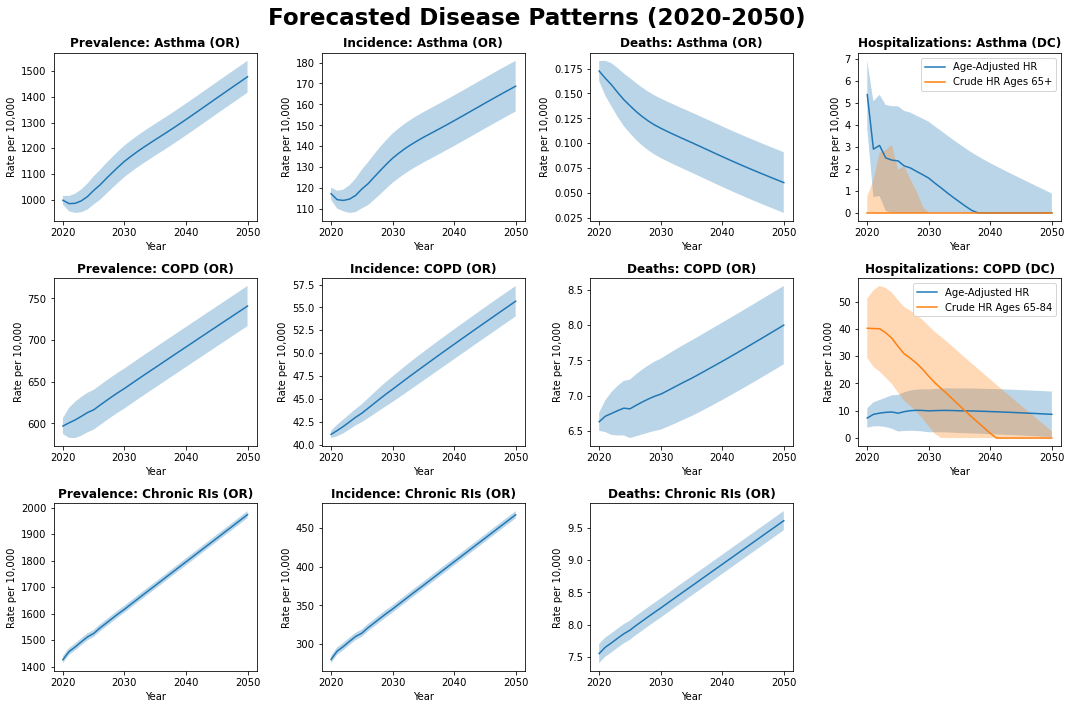

<Figure size 432x288 with 0 Axes>

In [61]:
# Select relevant columns
columns_to_plot = ['Prevalence: Asthma (OR)', 
                   'Incidence: Asthma (OR)', 
                   'Deaths: Asthma (OR)',
                   ('Asthma: Age-Adjusted HR (DC)', 'Asthma: Crude HR Ages 65+ (DC)'),
                   'Prevalence: Chronic obstructive pulmonary disease (OR)',
                   'Incidence: Chronic obstructive pulmonary disease (OR)', 
                    'Deaths: Chronic obstructive pulmonary disease (OR)',
                   ('COPD: Age-Adjusted HR (DC)', 'COPD: Crude HR Ages 65-84 (DC)'),
                   'Prevalence: Chronic respiratory diseases (OR)',
                   'Incidence: Chronic respiratory diseases (OR)',
                   'Deaths: Chronic respiratory diseases (OR)',
                  ]

# Set up the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

# Plot each variable with its confidence interval
for i, column in enumerate(columns_to_plot):
    if len(column) != 2:
        lower_bound = f'lower {column}'
        upper_bound = f'upper {column}'

        # Plot the variable
        sns.lineplot(data=forecast_df, x=forecast_df.index.year, y=column, ax=axes[i])#, label=variable)

        # Plot the confidence interval
        axes[i].fill_between(forecast_df.index.year, forecast_df[lower_bound], forecast_df[upper_bound], alpha=0.3)

        axes[i].set_title(
            column.replace("Chronic obstructive pulmonary disease", "COPD").replace(
            "respiratory diseases", "RIs"), weight='bold'
        )
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel(f'Rate per 10,000')
    if len(column) == 2:
        for col in column:
            variable = col.split(":")[0].strip()  # Extract the variable name
            category = col.split(":")[1].strip().split('(')[0].strip()
            lower_bound = f'lower {col}'
            upper_bound = f'upper {col}'

            # Plot the variable
            sns.lineplot(data=forecast_df, x=forecast_df.index.year, y=col, ax=axes[i], label=category)

            # Plot the confidence interval
            axes[i].fill_between(forecast_df.index.year, forecast_df[lower_bound], forecast_df[upper_bound], alpha=0.3)

            axes[i].set_title(f"Hospitalizations: {variable} (DC)", weight="bold")
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel(f'Rate per 10,000')
fig.delaxes(axes[-1])
# Adjust layout
plt.suptitle("Forecasted Disease Patterns (2020-2050)", fontsize=23,  weight='bold')
plt.tight_layout()
plt.show()

plt.savefig("./output/Forecasted_Disease_Patterns_2020-2050.png")

We see that all but hospitalization rates and asthma deaths is increasing steadily.

## Consider Correlation Between Variables
---
Let's find the correlation between each health variable and the annual smoke index.

In [63]:
import scipy as sp
def get_correlation_vars(var_name, alpha=0.05):
    """
    This function runs a Pearson and Spearman Correlation Test
    for a specified subset of health predictors from a subset decided earlier
    against the annual smoke index.
    
    Parameters:
        var_name: str, can be "Asthma", "COPD", or "Chronic RIs"
    Return
        dataframe with variable name, Pearson corr, and Spearman corr.
    """
    endog_vars = endog_col_dict[var_name] 
    pearson_corr_coefs = []
    spearman_corr_coefs = []
    c_vars = []
    for var in endog_vars:
        print(f"Checking {var}")
        df = merged_df[['Annual Smoke Index', var]].dropna()
        r1, p1 = sp.stats.pearsonr(df['Annual Smoke Index'], df[var])
        print(f"The R2 value is {r1**2} and Pearson correlation of {r1:0.5f}.")
        print(f"The p-value for the Pearson test is {p1:0.5f}")
        print("**Signficant**" if p1 < alpha else "")
        r, p = sp.stats.spearmanr(df['Annual Smoke Index'], df[var])
        print(f"The R2 value is {r**2} and Spearman rank correlation of {r:0.5f}.")
        print(f"The p-value for the Spearman rank test is {p:0.5f}")
        print("**Signficant**" if p < alpha else "")
        print("------------------------------------------------------------------")
        pearson_corr_coefs.append(r1)
        spearman_corr_coefs.append(r)
        c_vars.append(var.replace("Chronic obstructive pulmonary disease", "COPD").replace(
            "respiratory diseases", "RIs"))
    
    return pd.DataFrame({"Var": c_vars,
                         "Pearson": pearson_corr_coefs,
                         "Spearman": spearman_corr_coefs})
    

In [64]:
# Check Correlations for Asthma indicators
corr_coef_df = get_correlation_vars("Asthma")

Checking Deaths: Asthma (OR)
The R2 value is 0.5384917137616633 and Pearson correlation of -0.73382.
The p-value for the Pearson test is 0.00000
**Signficant**
The R2 value is 0.47286657650757685 and Spearman rank correlation of -0.68765.
The p-value for the Spearman rank test is 0.00003
**Signficant**
------------------------------------------------------------------
Checking Incidence: Asthma (OR)
The R2 value is 0.02091210869504627 and Pearson correlation of 0.14461.
The p-value for the Pearson test is 0.44580

The R2 value is 0.021104106527955302 and Spearman rank correlation of 0.14527.
The p-value for the Spearman rank test is 0.44370

------------------------------------------------------------------
Checking Prevalence: Asthma (OR)
The R2 value is 0.1083939053045037 and Pearson correlation of 0.32923.
The p-value for the Pearson test is 0.07564

The R2 value is 0.1428655000426874 and Spearman rank correlation of 0.37798.
The p-value for the Spearman rank test is 0.03946
**Signf

In [65]:
# Check Correlations for COPD indicators
corr_coef_df2 = get_correlation_vars("COPD")

Checking Deaths: Chronic obstructive pulmonary disease (OR)
The R2 value is 0.5526895228376913 and Pearson correlation of 0.74343.
The p-value for the Pearson test is 0.00000
**Signficant**
The R2 value is 0.5425739884014003 and Spearman rank correlation of 0.73660.
The p-value for the Spearman rank test is 0.00000
**Signficant**
------------------------------------------------------------------
Checking Incidence: Chronic obstructive pulmonary disease (OR)
The R2 value is 0.5179936202151262 and Pearson correlation of 0.71972.
The p-value for the Pearson test is 0.00001
**Signficant**
The R2 value is 0.5412638192726809 and Spearman rank correlation of 0.73571.
The p-value for the Spearman rank test is 0.00000
**Signficant**
------------------------------------------------------------------
Checking Prevalence: Chronic obstructive pulmonary disease (OR)
The R2 value is 0.4424428913526621 and Pearson correlation of 0.66516.
The p-value for the Pearson test is 0.00006
**Signficant**
The R

In [66]:
# Check Correlations for Chronic RI indicators
corr_coef_df3 = get_correlation_vars("Chronic RIs")

Checking Deaths: Chronic respiratory diseases (OR)
The R2 value is 0.5544496575801275 and Pearson correlation of 0.74461.
The p-value for the Pearson test is 0.00000
**Signficant**
The R2 value is 0.5425739884014003 and Spearman rank correlation of 0.73660.
The p-value for the Spearman rank test is 0.00000
**Signficant**
------------------------------------------------------------------
Checking Incidence: Chronic respiratory diseases (OR)
The R2 value is 0.26372986042747487 and Pearson correlation of 0.51355.
The p-value for the Pearson test is 0.00370
**Signficant**
The R2 value is 0.25122507890982565 and Spearman rank correlation of 0.50122.
The p-value for the Spearman rank test is 0.00478
**Signficant**
------------------------------------------------------------------
Checking Prevalence: Chronic respiratory diseases (OR)
The R2 value is 0.20161596260025214 and Pearson correlation of 0.44902.
The p-value for the Pearson test is 0.01281
**Signficant**
The R2 value is 0.23845677003

In [67]:
# let's combine all dataframes into one place
corr_coef_df = pd.concat([corr_coef_df,corr_coef_df2,corr_coef_df3])
# Rename variable column
corr_coef_df = corr_coef_df.rename(columns={"Var":"Indicator"})

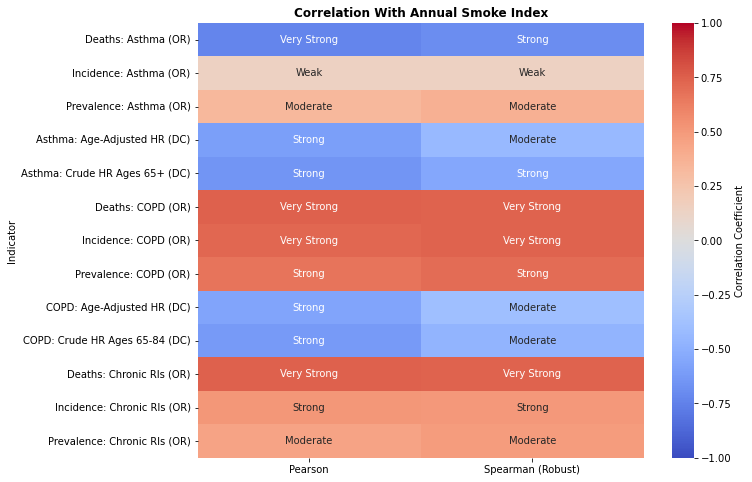

<Figure size 432x288 with 0 Axes>

In [69]:
# Function to categorize correlation strength and type
def categorize_correlation(correlation):
    """
    Bin correlation values into categories of 
    Weak, Moderate, Strong, and Very Strong.
    """
    if abs(correlation) <= 0.3:
        return 'Weak'
    elif 0.3 < abs(correlation) <= 0.5:
        return 'Moderate'
    elif 0.5 < abs(correlation) <= 0.7:
        return 'Strong'
    elif 0.7 < abs(correlation) <= 1:
        return 'Very Strong'

# Apply the categorize_correlation function to create a new column
corr_coef_df['Strength1'] = corr_coef_df['Pearson'].apply(categorize_correlation)
corr_coef_df['Strength2'] = corr_coef_df['Spearman'].apply(categorize_correlation)


# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_coef_df[['Indicator', 'Pearson', 'Spearman']].set_index("Indicator"), 
            annot=corr_coef_df[['Strength1', 'Strength2']], 
            cmap="coolwarm", fmt="", cbar=True,
            yticklabels=corr_coef_df['Indicator'], 
            xticklabels=['Pearson', 'Spearman (Robust)'], 
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation With Annual Smoke Index', weight="bold")
plt.show()
plt.savefig("./output/Respiratory_Health_Indicators_Correlation_Smoke.png")

   * 'Deaths: Chronic respiratory diseases (OR)',
   * 'Incidence: Asthma (OR)'
   * 'Incidence: Chronic obstructive pulmonary disease (OR)'
   * 'Incidence: Chronic respiratory diseases (OR)'
   * 'Prevalence: Asthma (OR)'
   * 'Prevalence: Chronic obstructive pulmonary disease (OR)'
   * 'Prevalence: Chronic respiratory diseases (OR)'
   * 'Asthma: Age-Adjusted HR (DC)', 
   * 'Asthma: Crude HR (DC)'
   * 'Asthma: Crude HR Ages 0-4 (DC)', 
   * 'Asthma: Crude HR Ages 5-14 (DC)'
   * 'Asthma: Crude HR Ages 15-34 (DC)', 
   * 'Asthma: Crude HR Ages 35-64 (DC)'
   * 'Asthma: Crude HR Ages 65+ (DC)', 
   * 'Asthma: Total Hospitalizations (DC)'
   * 'COPD: Age-Adjusted HR (DC)', 
   * 'COPD: Crude HR (DC)'
   * 'COPD: Crude HR Ages 25-44 (DC)'
   * 'COPD: Crude HR Ages 45-64 (DC)'
   * 'COPD: Crude HR Ages 65-84 (DC)'
   * 'PDR Age-Adjusted (DC)'
}